### Imports

In [66]:
# Standard library
import sqlite3
import os

# Third-party
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.inspection import permutation_importance
from sklearn.ensemble import RandomForestRegressor
from datetime import datetime, timedelta
from IPython.display import display
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt
from dotenv import load_dotenv
import pandas as pd
import numpy as np

# Local application
from kickbase_api.player_data import (
    get_all_players,
    get_player_id,
    get_player_info,
    get_player_market_value,
    get_player_performance,
)
from kickbase_api.league_data import (
    get_leagues_infos,
    get_budget,
    get_players_on_market,
)
from kickbase_api.user_management import login
from kickbase_api.team_data import get_matchdays

### Login to Kickbase

In [67]:
# Load environment variables from .env file
load_dotenv() 
USERNAME = os.getenv("KICK_USER")
PASSWORD = os.getenv("KICK_PASS")

# Login and get token
token = login(USERNAME, PASSWORD)
print("Logged in.")

Logged in.


### Connect to SQLite Database

In [68]:
conn = sqlite3.connect("bundesliga.db")
cursor = conn.cursor()

cursor.execute("""
CREATE TABLE IF NOT EXISTS player_data_1d (
    player_id INTEGER,
    team_id INTEGER,
    team_name TEXT,
    first_name TEXT,
    last_name TEXT,
    position TEXT,
    md DATE,
    date DATE,
    p REAL,
    mp INTEGER,
    ppm REAL,
    t1 INTEGER,
    t2 INTEGER,
    t1g INTEGER,
    t2g INTEGER,
    won INTEGER,
    k TEXT,
    mv REAL
);
""")

conn.commit()

### Get Player Data from Kickbase and Store in Database

In [69]:
competition_ids = [1]  # 1 = Bundesliga, 2 = 2. Bundesliga (für mehr Training)
last_mv_values = 365  # in Tagen, max 365
last_pfm_values = 50  # in Spieltagen
reload_data = False

# TODO: Change so this automatically fetches new data if the last entry is not up to date
# Check sysdate and time if before 22:00, then today should have no label for mv_target
# If after 22:00 then new mv available then fetch new data and update existing

if reload_data:
    all_competitions_dfs = []

    for competition_id in competition_ids:
        players = get_all_players(token, competition_id)

        def process_player(player_id):
            player_info = get_player_info(token, competition_id, player_id)
            player_team_id = player_info["team_id"]
            player_df = pd.DataFrame([player_info])

            # Market Value
            mv_df = pd.DataFrame(get_player_market_value(token, competition_id, player_id, last_mv_values))
            if not mv_df.empty:
                mv_df["date"] = pd.to_datetime(mv_df["date"]).sort_values()

            # Performance
            p_df = pd.DataFrame(get_player_performance(token, competition_id, player_id, last_pfm_values, player_team_id))
            if not p_df.empty:
                p_df["date"] = pd.to_datetime(p_df["date"]).sort_values()
            else:
                p_df = pd.DataFrame({"date": pd.to_datetime([])})

            # Merge DataFrames
            merged_df = (
                pd.merge_asof(mv_df, p_df, on="date", direction="backward")
                if not mv_df.empty else pd.DataFrame()
            )

            # Get p_df values where p_df.date > max(mv_df.date) and append to merged_df
            if not p_df.empty and not mv_df.empty:
                max_mv_date = mv_df["date"].max()
                additional_p_df = p_df[p_df["date"] > max_mv_date]
                merged_df = pd.concat([merged_df, additional_p_df], ignore_index=True) 

            if not merged_df.empty:
                merged_df = player_df.merge(merged_df, how="cross")
                merged_df["competition_id"] = competition_id

            return merged_df

        comp_dfs = list(map(process_player, players))
        comp_final_df = pd.concat(comp_dfs, ignore_index=True)
        all_competitions_dfs.append(comp_final_df)

    # Combine all competitions
    final_df = pd.concat(all_competitions_dfs, ignore_index=True)

    # Convert k column to string
    final_df["k"] = final_df["k"].apply(
        lambda x: ",".join(map(str, x)) if isinstance(x, list) else (None if x is None else str(x))
    )

    # Save to SQLite
    with sqlite3.connect("bundesliga.db") as conn:
        final_df.to_sql("player_data_1d", conn, if_exists="replace", index=False)


In [70]:
conn = sqlite3.connect("bundesliga.db")
df = pd.read_sql("SELECT * FROM player_data_1d", conn)
conn.close()

### Preprocess Data

In [71]:
# TODO: Change this to replace NaN with other values instead of dropping, so we keep our up-to-date data
#df = df.dropna(subset=["mv_next_day", "mv_target", "next_md", "days_to_next"])

# 1. Sort and filter
df = df.sort_values(["player_id", "date"])
df = df[(df["team_id"] == df["t1"]) | (df["team_id"] == df["t2"])]  # keep only t1 or t2

# Convert date columns to datetime
df["date"] = pd.to_datetime(df["date"])
df["md"] = pd.to_datetime(df["md"])

# 2. Date and matchday calculations 
df["next_day"] = df.groupby("player_id")["date"].shift(-1) 
df["next_md"] = df.groupby("player_id")["md"].transform(
    lambda x: x.shift(-1).where(x.shift(-1) != x).bfill()
)
df["days_to_next"] = (df["next_md"] - df["date"]).dt.days

# 3. Next day market value
df["mv_next_day"] = df.groupby("player_id")["mv"].shift(-1)
df["mv_target"] = df["mv_next_day"] - df["mv"]
df = df[df["mv"] != 0.0]

# 4. Feature engineering 
# Market value trend 1d
df["mv_change_1d"] = df["mv"] - df.groupby("player_id")["mv"].shift(1)
df["mv_trend_1d"] = df.groupby("player_id")["mv"].pct_change()
df["mv_trend_1d"] = df["mv_trend_1d"].replace([np.inf, -np.inf], 0).fillna(0)

# Market value trend 3d
df["mv_change_3d"] = df["mv"] - df.groupby("player_id")["mv"].shift(3)
df["mv_vol_3d"] = df.groupby("player_id")["mv"].rolling(3).std().reset_index(0,drop=True)

# Market value trend 7d
df["mv_trend_7d"] = df.groupby("player_id")["mv"].pct_change(periods=7)
df["mv_trend_7d"] = df["mv_trend_7d"].replace([np.inf, -np.inf], 0).fillna(0)

## League-wide market context
df["market_divergence"] = (df["mv"] / df.groupby("md")["mv"].transform("mean")).rolling(3).mean()

# 5. Clip outliers in mv_target
Q1 = df["mv_target"].quantile(0.25)
Q3 = df["mv_target"].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 2.5 * IQR
upper_bound = Q3 + 2.5 * IQR

df["mv_target_clipped"] = df["mv_target"].clip(lower_bound, upper_bound)

# 6. Fill missing values
df = df.fillna({
    "market_divergence": 1,
    "mv_change_3d": 0,
    "mv_vol_3d": 0,
    "p": 0,
    "ppm": 0,
    "won": -1
})

# 7. Cutout todays values and store them
now = datetime.now()
max_date = (now - timedelta(days=1)) if now.hour <= 22 else now
max_date = max_date.date()
print(max_date)

today_df = df[df["date"].dt.date >= max_date]

# Drop those values from today from df
df = df[df["date"].dt.date < max_date]

# 8. Drop rows with NaN in critical columns
df = df.dropna(subset=["mv_change_1d", "next_day", "next_md", "days_to_next", "mv_next_day", "mv_target", "mv_target_clipped"])

C:\Users\lenna\AppData\Local\Temp\ipykernel_18960\2216583283.py:27: FutureWarning: The default fill_method='ffill' in SeriesGroupBy.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  df["mv_trend_1d"] = df.groupby("player_id")["mv"].pct_change()
C:\Users\lenna\AppData\Local\Temp\ipykernel_18960\2216583283.py:35: FutureWarning: The default fill_method='ffill' in SeriesGroupBy.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  df["mv_trend_7d"] = df.groupby("player_id")["mv"].pct_change(periods=7)


2025-08-29


### Select Features and Target Variable

In [72]:
# TODO Features: Fit or Injury and Starting Eleven Prediction
features = [
    "p", "mv", "days_to_next", 
    "mv_change_1d", "mv_trend_1d", 
    "mv_change_3d", "mv_vol_3d",
    "mv_trend_7d", "market_divergence"
]

target = "mv_target_clipped" # or "mv_target"

# Split by time, to avoid data leakage
train = df[df["date"] < "2025-01-01"]
test = df[(df["date"] >= "2025-01-01")]

X_train = train[features]
y_train = train[target]

X_test = test[features]
y_test = test[target]

### Train Machine Learning Model

In [73]:
model = RandomForestRegressor(
    n_estimators=500,
    max_depth=20,
    min_samples_split=5,
    min_samples_leaf=2,
    max_features="sqrt",
    n_jobs=-1
)

model.fit(X_train, y_train)

y_pred = model.predict(X_test)

rmse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
signs_correct = np.sum(np.sign(y_test) == np.sign(y_pred))

print(f"Sign accuracy: {np.round((signs_correct / len(y_test)) * 100, 2)}%")
print(f"RMSE: {np.round(rmse, 2)}")
print(f"MAE: {np.round(mae, 2)}")
print(f"R²: {np.round(r2, 3)}")

Sign accuracy: 66.2%
RMSE: 3043015335.25
MAE: 28026.26
R²: 0.808


### Example Player Prediction

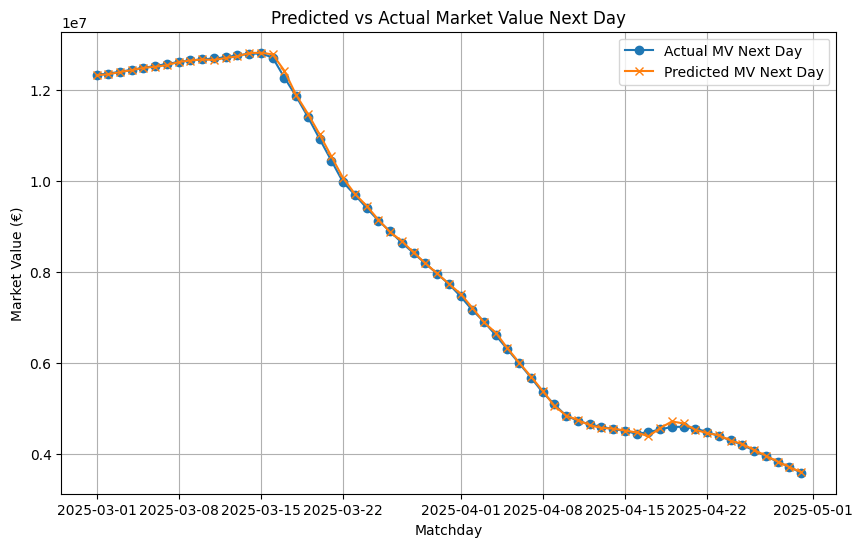

In [74]:
small_test = test[["player_id", "first_name", "last_name", "date", "mv", "mv_next_day", "mv_target"]].copy()

small_test["predicted_mv_target"] = np.round(y_pred, 2)
small_test["predicted_mv_next_day"] = small_test["mv"] + small_test["predicted_mv_target"]


# get error between prediction and actual 
small_test["error"] = small_test["mv_next_day"] - small_test["predicted_mv_next_day"]

# Sort by error ascending

small_test = small_test.sort_values("date")

small_test = small_test[(small_test["last_name"] == "Uzun")]


# Filter small test only between 2025-03 and 2025-04
small_test = small_test[(small_test["date"] >= "2025-03-01") & (small_test["date"] <= "2025-04-30")]


# Plot predicted vs actual mv_next_week
plt.figure(figsize=(10, 6))
plt.plot(small_test["date"], small_test["mv_next_day"], marker='o', label="Actual MV Next Day")
plt.plot(small_test["date"], small_test["predicted_mv_next_day"], marker='x', label="Predicted MV Next Day")
plt.xlabel("Matchday")
plt.ylabel("Market Value (€)")
plt.title("Predicted vs Actual Market Value Next Day")
plt.legend()
plt.grid(True)


### Feature Importance

In [75]:
#perm_importance = permutation_importance(model, X_test, y_test, n_repeats=10, random_state=42, n_jobs=-1)
#
#perm_df = pd.DataFrame({
#    'feature': features,
#    'importance': perm_importance.importances_mean
#}).sort_values(by='importance', ascending=False)
#
## Plot
#plt.figure(figsize=(10,6))
#plt.barh(perm_df['feature'], perm_df['importance'])
#plt.gca().invert_yaxis()
#plt.title("Feature Importance")
#plt.xlabel("Decrease in Model Score")
#plt.show()

### Predicted vs Actual Values

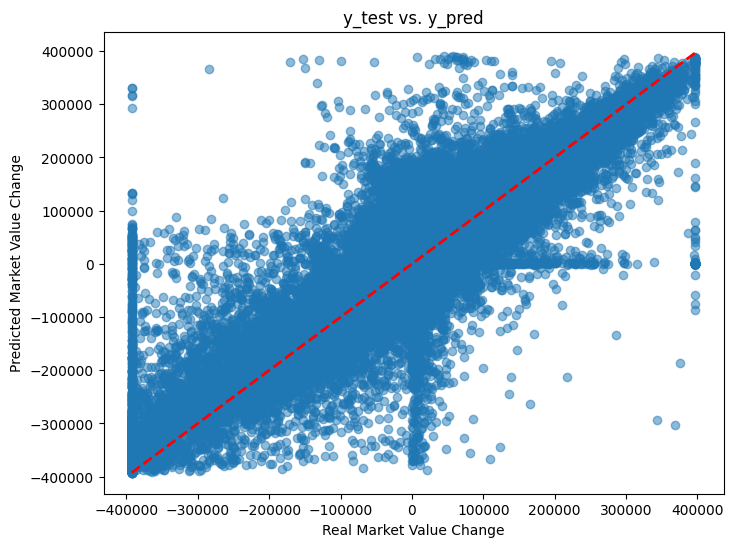

In [76]:
plt.figure(figsize=(8,6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)  # Perfect prediction line
plt.xlabel("Real Market Value Change")
plt.ylabel("Predicted Market Value Change")
plt.title("y_test vs. y_pred")
plt.show()

### Live Data Prediction

In [77]:
today_df_features = today_df[features]

today_df_results = today_df.copy()

today_df_results["predicted_mv_target"] = np.round(model.predict(today_df_features), 2)

# Sort by predicted_mv_target descending
today_df_results = today_df_results.sort_values("predicted_mv_target", ascending=False)

# Filter date to today 
now = datetime.now()
date = (now - timedelta(days=1)) if now.hour <= 22 else now
date = date.date()
today_df_results = today_df_results[today_df_results["date"].dt.date == date]

# Drop rows where NaN mv
today_df_results = today_df_results.dropna(subset=["mv"])

# Keep only relevant columns
today_df_results = today_df_results[["player_id", "first_name", "last_name", "position", "team_name", "date", "mv_change_1d", "mv_trend_1d", "mv", "predicted_mv_target"]]

display(today_df_results)

,player_id,first_name,last_name,position,team_name,date,mv_change_1d,mv_trend_1d,mv,predicted_mv_target
149959,6750,Ilyas,Ansah,4,Union Berlin,2025-08-29,381508.0,0.047606,8395431.0,348551.41
15013,6293,Danel,Sinani,3,St. Pauli,2025-08-29,331610.0,0.038619,8918348.0,302184.37
61612,3228,Justin,Njinmah,4,Bremen,2025-08-29,302661.0,0.036193,8665141.0,283072.53
121778,7877,Andreas,Skov Olsen,3,Wolfsburg,2025-08-29,307947.0,0.034955,9117875.0,272832.66
10254,11752,Warmed,Omari,2,Hamburg,2025-08-29,275072.0,0.039947,7160988.0,262068.35
...,...,...,...,...,...,...,...,...,...,...
82162,6672,Xavi,Simons,3,Leipzig,2025-08-29,-1269851.0,-0.040656,29964521.0,-384268.25
43262,2758,Nick,Woltemade,4,Stuttgart,2025-08-29,-1641435.0,-0.050979,30556619.0,-384336.15
120680,7236,Joakim,Mæhle,2,Wolfsburg,2025-08-29,-476538.0,-0.042996,10606725.0,-388490.05
59410,1996,Marco,Friedl,2,Bremen,2025-08-29,-555755.0,-0.048297,10951221.0,-388754.55


In [78]:
# Bid pipeline
# 1. Check available player on market
# 2. Check available budget
# 3. Check how long until next matchday (money cant be negative then)
# 4. Check team size and club limit
# 5. Based upon prediction and other factors

# long term prediction?

In [80]:
league_infos = get_leagues_infos(token)
league_id = league_infos[0]["id"]

players_on_market = get_players_on_market(token, league_id)

# players_on_market to DataFrame
market_df = pd.DataFrame(players_on_market)

# Join market_df ("id") with today_df ("player_id")
bid_df = (
    pd.merge(today_df_results, market_df, left_on="player_id", right_on="id")
    .drop(columns=["id"])
)

# Sort by predicted_mv_target descending
bid_df = bid_df.sort_values("predicted_mv_target", ascending=False)
display(bid_df)

,player_id,first_name,last_name,position,team_name,date,mv_change_1d,mv_trend_1d,mv,predicted_mv_target,prob,exp
0,10105,Bazoumana,Touré,3,Hoffenheim,2025-08-29,258426.0,0.030608,8701630.0,216312.27,1,16762
1,2038,Konrad,Laimer,2,Bayern,2025-08-29,82649.0,0.003410,24317618.0,90685.23,2,35818
2,2074,Robin,Hack,3,M'gladbach,2025-08-29,67270.0,0.003829,17637741.0,79958.88,1,2019484
3,10114,Carney,Chukwuemeka,3,Dortmund,2025-08-29,173021.0,0.019691,8959974.0,68966.41,5,55877
4,2274,Keven,Schlotterbeck,2,Augsburg,2025-08-29,118695.0,0.011262,10657980.0,46809.61,1,55300
5,6077,David,Odogu,2,Wolfsburg,2025-08-29,86983.0,0.038361,2354447.0,29361.24,5,2019471
6,4312,Yan,Couto,2,Dortmund,2025-08-29,158283.0,0.018009,8947233.0,-6839.32,1,2263500
7,2846,Malik,Tillman,3,Leverkusen,2025-08-29,-33879.0,-0.001507,22441165.0,-29812.67,4,18
8,4576,Andreas,Hanche-Olsen,2,Mainz,2025-08-29,-63643.0,-0.014542,4312810.0,-53948.89,4,10872
9,7215,Jordy,Makengo,2,Freiburg,2025-08-29,-95205.0,-0.022218,4189765.0,-88921.89,3,2453936


### Testinggg

,mv,date
0,0.0,2024-08-29
1,0.0,2024-08-30
2,0.0,2024-08-31
3,0.0,2024-09-01
4,0.0,2024-09-02
...,...,...
360,500000.0,2025-08-24
361,500000.0,2025-08-25
362,500000.0,2025-08-26
363,500000.0,2025-08-27


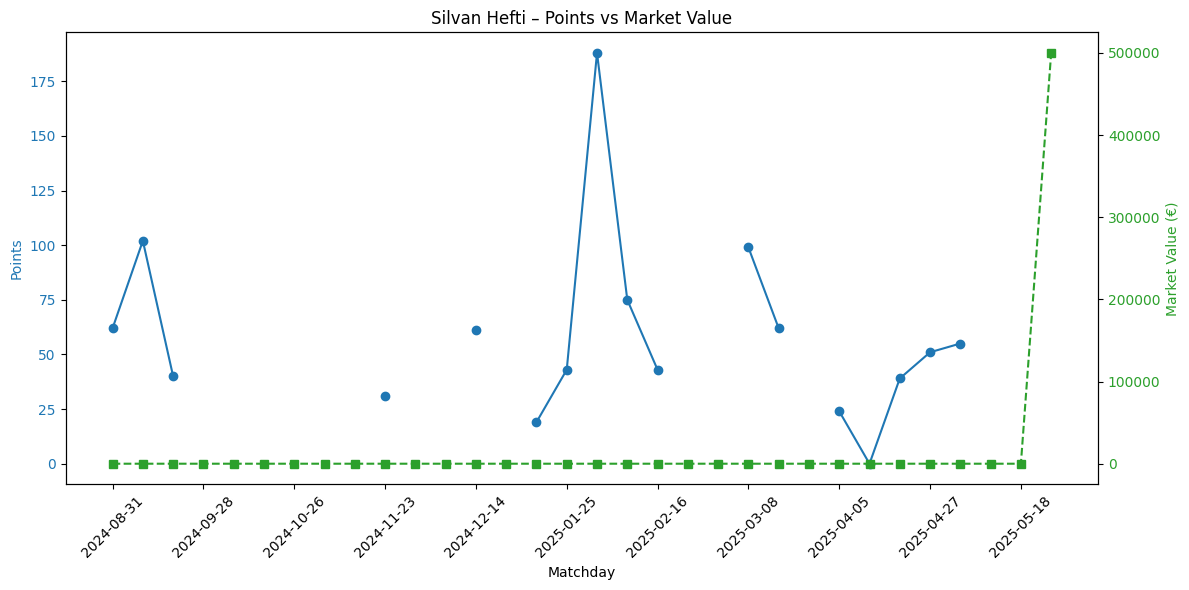

In [ ]:
# we need competition_id, player_id, timeframe
competition_id = 1 # 1 is for Bundesliga, info from github issue thread
last_mv_values = 365 # in days, max 365
last_pfm_values = 50 # in matchdays
player_name = "Silvan Hefti" # Example player

# Get player ID
player_id = get_player_id(token, competition_id, player_name)

# Get player info
player_info = get_player_info(token, competition_id, player_id)
player_team_id = player_info["team_id"]
player_df = pd.DataFrame([player_info])

# Get player market value
market_value = get_player_market_value(token, competition_id, player_id, last_mv_values)
mv_df = pd.DataFrame(market_value)

display(mv_df)

# Get player performance
performance = get_player_performance(token, competition_id, player_id, last_pfm_values, player_team_id)
p_df = pd.DataFrame(performance)

# Merge on 'date'
merged_df = pd.merge(p_df, mv_df, on="date", how="inner")
merged_df = player_df.merge(merged_df, how="cross")

#display(merged_df)

# Ensure correct column names (adjust if needed)
points_col = "p"          # from performance
mv_col = "mv"         # from market value
matchday_col = "date"            # common key

fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot Points (left y-axis)
color = "tab:blue"
ax1.set_xlabel("Matchday")
ax1.set_ylabel("Points", color=color)
ax1.plot(merged_df[matchday_col], merged_df[points_col], 
         marker="o", linestyle="-", color=color, label="Points")
ax1.tick_params(axis="y", labelcolor=color)

# X-axis formatting
ax1.xaxis.set_major_locator(ticker.MaxNLocator(integer=True, nbins=15))  # max ~15 ticks
plt.xticks(rotation=45)

# Create second axis for Market Value (right y-axis)
ax2 = ax1.twinx()
color = "tab:green"
ax2.set_ylabel("Market Value (€)", color=color)
ax2.plot(merged_df[matchday_col], merged_df[mv_col], 
         marker="s", linestyle="--", color=color, label="Market Value")
ax2.tick_params(axis="y", labelcolor=color)

# Title and layout
plt.title(f"{player_name} – Points vs Market Value")
fig.tight_layout()
plt.show()